In [207]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

# Check for MPS availability and set the device
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print(f"Using device: {device}")

Using device: mps


In [208]:
# Load your data
data = pd.read_csv('eth_usd_candles.csv')
test_data = pd.read_csv('eth_2022_2023.csv')

# Select multiple features
features = data[['open', 'high', 'low', 'close']].values.astype(np.float32)
features_test = test_data[['open', 'high', 'low', 'close']].values.astype(np.float32)

# Normalize features
mean = features.mean(axis=0)
std = features.std(axis=0)
features_normalized = (features - mean) / std

#Normalize Test features
mean_test = features_test.mean(axis=0)
std_test = features_test.std(axis=0)
features_normalized_test = (features_test - mean_test) / std_test

# Convert to PyTorch tensor
features_tensor = torch.tensor(features_normalized)
features_tensor_test = torch.tensor(features_normalized_test)

In [209]:
# # Function to split data
# def train_test_split(data, test_size=0.20):
#     n_samples = len(data)
#     split_point = int(n_samples * (1 - test_size))
#     return data[:split_point], data[split_point:]

In [210]:
# Split the normalized prices into training and test datasets
# train_data, test_data = train_test_split(features_tensor)

In [211]:
# Function to create sequences
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i + seq_length]
        y = data[i + seq_length, 3]
        xs.append(x)
        ys.append(y)
    return torch.stack(xs), torch.stack(ys)

In [212]:
seq_length = 10  # Number of time steps to look back
X_train, y_train = create_sequences(features_tensor, seq_length)
X_test, y_test = create_sequences(features_tensor_test, seq_length)

In [213]:
# Create DataLoaders
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=64, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=64, shuffle=False)

In [214]:
# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size=4, hidden_layer_size=100, output_size=1):
        super(LSTMModel, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True)
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        lstm_out, _ = self.lstm(input_seq)
        predictions = self.linear(lstm_out[:, -1])
        return predictions

model = LSTMModel().to(device)

In [215]:
# Training function
def train_model(model, train_loader, epochs=50):
    model.train()
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(epochs):
        with tqdm(train_loader, unit="batch") as tepoch:
            for seq, labels in tepoch:
                tepoch.set_description(f"Epoch {epoch + 1}")
                
                seq, labels = seq.to(device), labels.to(device)
                optimizer.zero_grad()
                y_pred = model(seq)
                loss = criterion(y_pred, labels)
                loss.backward()
                optimizer.step()
                
                tepoch.set_postfix(loss=loss.item())

# Train the model
train_model(model, train_loader)

Epoch 1:   0%|          | 0/2338 [00:00<?, ?batch/s]/opt/anaconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:533: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 1: 100%|█████████▉| 2333/2338 [00:13<00:00, 171.03batch/s, loss=0.0322]  /opt/anaconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:533: UserWarning: Using a target size (torch.Size([6])) that is different to the input size (torch.Size([6, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 50: 100%|██████████| 2338/2338 [00:13<00:00, 175.64batch/s, loss=0.00197] 


In [216]:
# Evaluate the model
def evaluate_model(model, test_loader):
    model.eval()
    predictions = []
    actuals = []
    with torch.no_grad():
        for seq, labels in test_loader:
            seq = seq.to(device)
            output = model(seq)
            predictions.extend(output.cpu().numpy())
            actuals.extend(labels.cpu().numpy())

    return predictions, actuals

predictions, actuals = evaluate_model(model, test_loader)

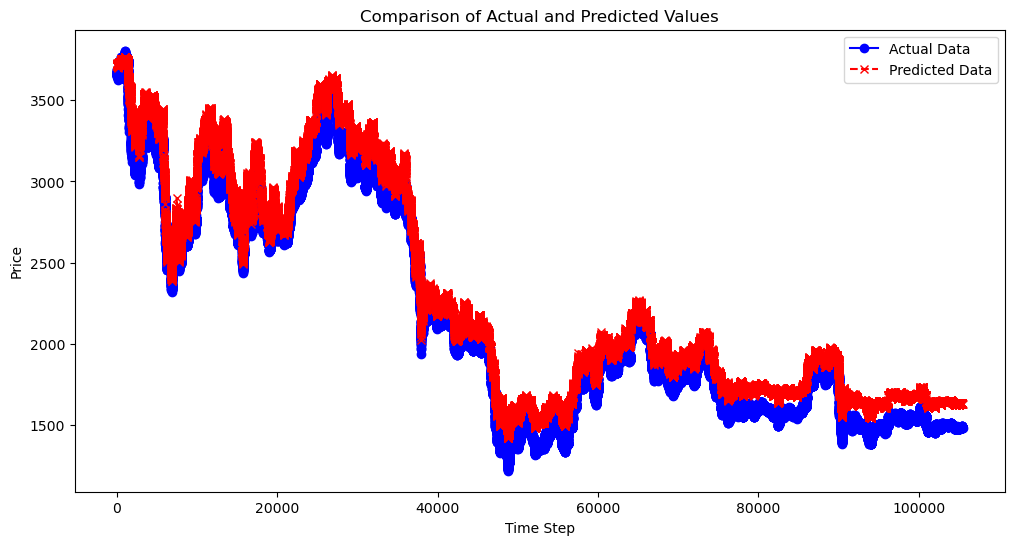

In [225]:
import numpy as np
import matplotlib.pyplot as plt

predictions_array = np.array(predictions).flatten()  # Model's predictions
actuals_array = np.array(actuals).flatten()          # Actual values for comparison

# Mean and std deviation used for normalization
mean = features.mean(axis=0)[3]
std = features.std(axis=0)[3]

# Reverse standardization
predictions_array = predictions_array * std + mean
actuals_array = actuals_array * std + mean

# Create a plot
plt.figure(figsize=(12, 6))
plt.plot(actuals_array, label='Actual Data', color='blue', marker='o')
plt.plot(predictions_array, label='Predicted Data', color='red', linestyle='dashed', marker='x')
plt.title('Comparison of Actual and Predicted Values')
plt.xlabel('Time Step')
plt.ylabel('Price')
plt.legend()
plt.show()


In [218]:
data.corr(numeric_only=True)

,low,high,open,close,volume
low,1.000000,0.999978,0.999985,0.999989,-0.046525
high,0.999978,1.000000,0.999989,0.999990,-0.041833
open,0.999985,0.999989,1.000000,0.999982,-0.043811
close,0.999989,0.999990,0.999982,1.000000,-0.044038
volume,-0.046525,-0.041833,-0.043811,-0.044038,1.000000


In [219]:
# Save the model state dictionary
torch.save(model.state_dict(), 'model.pth')

In [232]:
import pandas as pd

# Generate timestamps every 5 minutes from 2022-01-01 to just before 2023-01-01
start_date = "2022-01-01 00:00:00"
end_date = "2023-01-01 00:00:00"
timestamps = pd.date_range(start=start_date, end=end_date, freq='5T')

# Remove the last timestamp if it exactly equals the end_date
if timestamps[-1] == pd.Timestamp(end_date):
    timestamps = timestamps[:-1]

# Convert to string if needed (depending on how your DB expects timestamp)
timestamps = timestamps.strftime('%Y-%m-%d %H:%M:%S').tolist()

# Printing number of intervals
print(f"Expected number of intervals: {len(timestamps)}")


Expected number of intervals: 105120


In [240]:
import numpy as np

predictions_normalized = np.array(predictions).flatten()
predictions = predictions_normalized * std + mean  # Reverse standardization


In [244]:
import pandas as pd

# Load your data
data = pd.read_csv('eth_2022_2023.csv')

timestamps = data['time'].tolist()  # Convert the timestamp column to a list
trimmed_timestamps = timestamps[:-10]  # This removes the last 10 elements

print(f"Number of timestamps: {len(trimmed_timestamps)}")
print(f"Number of predictions: {len(predictions)}")

print(f"First timestamp: {trimmed_timestamps[0]}")

Number of timestamps: 105474
Number of predictions: 105474
First timestamp: 2022-01-01 00:00:00


In [245]:
import psycopg2

def append_to_postgres(cur, time, close):
    cur.execute("INSERT INTO eth_model_predictions_2022_2023(time, close) VALUES (%s, %s)",
                (time, close))

# Database configuration
conn = psycopg2.connect(
    database="ethereum", 
    user="postgres", 
    password="PASSWORD", 
    host="localhost", 
    port="5432"
)
cur = conn.cursor()

# Insert data into the database
for time, close in zip(trimmed_timestamps, predictions):
    # Ensure 'close' is a native Python float
    close = float(close)  # Convert NumPy float32 to native Python float
    append_to_postgres(cur, time, close)


# Commit changes and close connection
conn.commit()
cur.close()
conn.close()
